In [148]:
import os
os.chdir('./drive/My Drive/Challenge-Owkin/')

FileNotFoundError: ignored

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Metrics

In [0]:
import numpy as np
import pandas as pd
import warnings


def cindex(y_true_times, predicted_times, tol=1e-8):
    """
    Author: Romuald Menuet & Rémy Dubois

    Evaluate concordance index from Pandas DataFrame, taking ties into account.

    Args:
        y_true_times: pd.DataFrame
            pd DataFrame with three columns: `PatientID`, `Event` and `SurvivalTime` the float-valued column of true survival times.
        predicted_times: pd.DataFrame
            pd DataFrame with three columns: `PatientID`, `SurvivalTime` the float-valued column of predicted survival times,
            and one `Event`column, whose value does not matter. It must be appended so that target and predictions have the same format.
        tol: float
            small float value for numerical stability.
    Returns:
        Concordance index, as described here:
        https://square.github.io/pysurvival/metrics/c_index.html
    """

    assert isinstance(y_true_times, pd.DataFrame), 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert isinstance(predicted_times, pd.DataFrame), 'Predicted times should be pd dataframe with patient `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert len(y_true_times.shape) == 2, 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert len(predicted_times.shape) == 2, 'Predicted times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert set(y_true_times.columns) == {'Event', 'SurvivalTime'}, 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert set(predicted_times.columns) == {'Event', 'SurvivalTime'}, 'Predicted times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    np.testing.assert_equal(y_true_times.shape, predicted_times.shape, err_msg="Not same amount of predicted versus true samples")
    assert set(y_true_times.index) == set(predicted_times.index), 'Not same patients in prediction versus ground truth'
    assert np.all(predicted_times['SurvivalTime'] > 0), 'Predicted times should all be positive'

    events = y_true_times.Event
    y_true_times = y_true_times.SurvivalTime
    predicted_times = predicted_times.SurvivalTime

    # Just ordering the right way
    predicted_times = predicted_times.loc[y_true_times.index]
    events = events.loc[y_true_times.index]

    events = events.values.astype(int)
    y_true_times = y_true_times.values.astype(float)
    predicted_times = predicted_times.values.astype(float)
    # events = events.values.astype(bool)

    np.testing.assert_array_less(1.,
                                 predicted_times.astype(float),
                                 err_msg="Predicted y_true_times all below 1.\
                                 It should be in days. Make sure that you are not predicting risk instead of time.")

    return _cindex_np(y_true_times, predicted_times, events)


def _cindex_np(times, predicted_times, events, tol=1.e-8):
    """
    Raw CI computation from np arrray. Should not be used as is.
    """
    assert times.ndim == predicted_times.ndim == events.ndim == 1, "wrong input, should be vectors only"
    assert times.shape[0] == predicted_times.shape[0] == events.shape[0], "wrong input, should be vectors of the same len"

    risks = - predicted_times

    risks_i = risks.reshape((-1, 1))
    risks_j = risks.reshape((1, -1))
    times_i = times.reshape((-1, 1))
    times_j = times.reshape((1, -1))
    events_i = events.reshape((-1, 1))

    eligible_pairs = (times_i < times_j) * events_i

    well_ordered = np.sum(eligible_pairs * (risks_i > risks_j))
    ties = + np.sum(eligible_pairs * 0.5 * (risks_i == risks_j))

    return (well_ordered + ties) / (eligible_pairs.sum() + tol)


# Read files

In [0]:
from sklearn import preprocessing

def normalizing_input(x_train, x_test):
    all_x = pd.concat([x_train, x_test])
    x_val = all_x.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x_val)
    df = pd.DataFrame(x_scaled, index=all_x.index, columns=all_x.columns)
    return df.loc[x_train.index], df.loc[x_test.index]

def cleaning_clinical(clinical):
    """
    Cleaning the clinical dataframe.
    :param clinical:
    :return:
    """
    # Encoding label for SourceDataset
    le = preprocessing.LabelEncoder()
    le.fit(clinical['SourceDataset'])
    le.transform(clinical['SourceDataset'])
    clinical['SourceDataset'] = le.transform(clinical['SourceDataset'])
    # Cleaning Histology
    clinical.replace("NSCLC NOS (not otherwise specified)", "nos", inplace=True)
    clinical.replace("Adenocarcinoma", "adenocarcinoma", inplace=True)
    clinical.replace("Squamous cell carcinoma", "squamous cell carcinoma", inplace=True)
    # Dummies for Histology
    clinical = pd.get_dummies(clinical)
    # Fill age nan
    clinical['age'].fillna((clinical['age'].mean()), inplace=True)

    return clinical

def clean_clinical_data(file, newfile):
    """
    Cleaning clinical data.
    :param file: clinical data file
    :param newfile: path for the cleaned data file.
    :return:
    """
    clinical = pd.read_csv(file, index_col=0)
    cleaned = cleaning_clinical(clinical)
    cleaned.to_csv(newfile)

def y_dataframe_to_rsf_input(y_df):
    """
    Input for random survival forest.
    :param y_df: event + survival time dataframe.
    :return:
    """
    y_array = []
    Y = y_df.to_numpy()
    for y in Y:
        tuple = (bool(y[1]), y[0])
        y_array.append(tuple)
    return np.array(y_array, dtype = [(f'{y_df.columns[1]}', np.bool), (f'{y_df.columns[0]}', np.float)])

In [0]:
def read_input(file_radiomics, file_clinical):
    """
    Read radiomics and clinical feature and return dataframe.
    :param file_radiomics: filename
    :param file_clinical: filename
    :return:
    """
    radiomics = pd.read_csv(file_radiomics, index_col=0)
    clinical = pd.read_csv(file_clinical, index_col=0)
    clinical = cleaning_clinical(clinical)
    input = pd.concat([radiomics, clinical], axis=1)
    return input

def read_output(file_output):
    """
    Return dataframe for event + survival time.
    :param file_output:
    :return:
    """
    output = pd.read_csv(file_output, index_col=0, header=0)
    return output

def load_owkin_data(radiomics_path_train="data/train/features/radiomics.csv",
                    clinical_path_train="data/train/features/clinical_data.csv",
                    label_path_train='data/train/y_train.csv',
                    radiomics_path_test="data/test/features/radiomics.csv",
                    clinical_path_test="data/test/features/clinical_data.csv"):
    """
    Load Owkin data: return PyRadiomics + clinical features of training set in dataframe,
                    event + time of training set in dataframe, and
                    PyRadiomics + clinical features of testing set in dataframe,
    """
    input_train = read_input(radiomics_path_train, clinical_path_train)
    output_train = read_output(label_path_train)
    input_test = read_input(radiomics_path_test, clinical_path_test)
    return input_train, output_train, input_test


input_train, output_train, input_test = load_owkin_data()
all_features = input_train.columns

# Data exploration

## Global distribution

In [205]:
x_train, y_train, x_test = load_owkin_data()
x_train

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Mstage,Nstage,SourceDataset,Tstage,age,Histology_adenocarcinoma,Histology_large cell,Histology_nos,Histology_squamous cell carcinoma
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,1.592466,241.0,-310.858031,288.311105,-266.0,-1006.0,1247.0,446.407319,-0.281714,320.385361,0.037008,102646.779451,1056.843506,546253.499762,-5334.563631,555.818455,54.336816,0.821101,3.845383,5.036775,0.005920,9.270194,0.338672,0.262780,-0.175185,0.901525,0.981053,0.917509,0.249416,0.037768,61.035662,6.007130,0.926391,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761,0,0,1,2,66.000000,1,0,0,0
371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,3.371013,262.0,-134.429809,191.395154,-15.0,-945.0,1207.0,268.966000,-1.216062,232.962090,0.080061,54271.335557,1219.689108,331155.230396,-6857.579704,295.032309,16.868781,0.891184,2.984034,2.570017,0.025532,7.551168,0.495719,0.439879,-0.250370,0.932847,0.993282,0.953464,0.340024,0.110575,67.826804,5.255594,0.855154,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589,0,2,0,4,64.572200,0,1,0,0
246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,7.585494,115.0,-54.136093,94.132136,2.0,-785.0,900.0,141.852795,-2.153344,131.116356,0.160905,17191.498865,972.465798,54523.086867,-1618.363118,78.183970,7.040623,0.831081,2.333939,1.496020,0.066569,5.686554,0.616607,0.581458,-0.249969,0.884911,0.995095,0.963887,0.379957,0.189723,61.795144,4.159019,0.769265,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080,0,3,0,2,66.045200,0,0,0,1
240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,4.281865,274.0,-118.705522,149.072998,-37.0,-850.0,1124.0,224.397694,-1.437836,190.429315,0.074476,36263.324022,968.117567,166735.779994,-3968.921514,184.299591,13.656782,0.860096,2.926791,2.492079,0.015048,7.536161,0.457545,0.391681,-0.214233,0.902811,0.993509,0.950374,0.357236,0.050439,60.841486,5.122729,0.880123,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046,0,2,0,3,59.356600,0,0,1,0
284,0.0236

## Low and high survival probability population

En regardant le temps de survie dans patients labelisé Event = 0 ou Event = 1, j'ai splitté deux groupes de populations, une qui a une très faible chance de survie, et une autre avec une grand chance de survie, pour voir si ces deux groupes avaient des valeurs de features caractéristiques. Résultat: y'a juste deux features très discriminants, SourceDataset (ce qui est assez vache) et Histology_adenocarcinoma, et quelques autres qui discriminent un peu (les valeurs moyennes sont assez proches, mais la dispersion est encore petite pour pouvoir dire qu'on a deux groupes différents). Pour les autres, soit la dispersion est trop grande donc on peut rien dire, soit au contraire ces features se concentrent autour de la même valeur pour les deux populations, donc ça permet pas de différencier les populations. Le dataset en soi est donc assez difficile. Je pense que dans un premier temps faut tèje les variables inutiles (trop dispersées ou non informatives), ça sera la partie feature sélection, et après l'idéal c'est de construire des nouveaux features discriminants à partir du set restreint de features PyRadiomics / clinique, et images.

In [0]:
x_train, y_train, x_test = load_owkin_data()
x_train, x_test = normalizing_input(x_train, x_test)

Text(0.5, 1.0, 'Histogram distribution according to event')

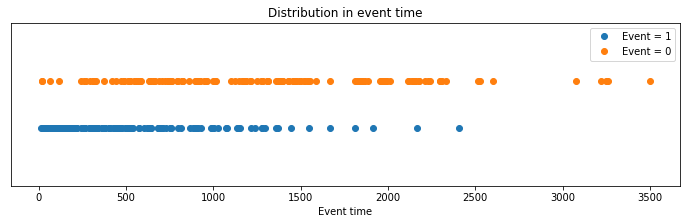

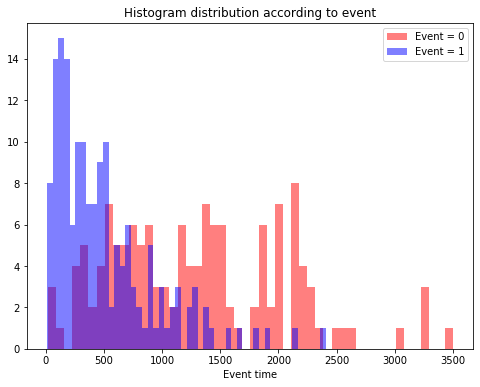

In [0]:
""" Distribution of patient in event time """
dead = y_train.loc[y_train['Event'] == 1]['SurvivalTime']
alive = y_train.loc[y_train['Event'] == 0]['SurvivalTime']

plt.figure(figsize=(12, 3))
plt.plot(dead, np.zeros(len(dead)), 'o', label='Event = 1')
plt.plot(alive, np.zeros(len(alive)) + 0.4, 'o', label='Event = 0')
plt.ylim([-0.5, 0.9])
plt.xlabel('Event time')
plt.yticks([])
plt.legend()
plt.title('Distribution in event time')

plt.figure(figsize=(8,6))
n_bins = 50
plt.hist(alive, bins = n_bins, fc=(1, 0, 0, 0.5), label = 'Event = 0')
plt.hist(dead, bins = n_bins, fc=(0, 0, 1, 0.5), label = 'Event = 1')
plt.legend()
plt.xlabel('Event time')
plt.title('Histogram distribution according to event')


**Hypothesis**: Patients with event 1 (people who died in the experience) with an event time less than 300 are considered as low survival probability patients. Patients with event 0 (people who are still alive in the experience) with an event time higher than 2000 are considered as high survival probability patients.

In [0]:
""" Low survival probability patients """
dead_df = y_train.loc[y_train['Event'] == 1] 
low_survival_index = dead_df.loc[dead_df['SurvivalTime'] <= 300].index
low_surv_df = x_train.loc[low_survival_index]
print(f'Number of low survival probability patients: {len(low_survival_index)}')
print(low_survival_index)

""" High survival probability patients """
alive_df = y_train.loc[y_train['Event'] == 0]
high_survival_index = alive_df.loc[alive_df['SurvivalTime'] >= 2000].index
high_surv_df = x_train.loc[high_survival_index]
print(f'Number of high survival probability patients: {len(high_survival_index)}')
print(high_survival_index)

Number of low survival probability patients: 66
Int64Index([384, 100, 173,  83, 149, 316, 340, 359, 210, 250, 262, 147, 224,
            272, 418, 116,  30,  29, 266, 175, 303, 367, 208,  17, 237, 355,
            294, 107, 397,  67,  24, 138, 124, 145, 126, 282, 382,  76, 196,
            309, 385,  43, 269,  21,  98, 183, 383,  26, 347,  14, 400, 328,
             15, 358, 159,  93, 255, 395, 346, 112, 345, 299, 373, 213,  56,
            365],
           dtype='int64', name='PatientID')
Number of high survival probability patients: 25
Int64Index([284, 143,  94, 380,  48, 334, 257, 403, 130, 275, 406, 305,  25,
            184, 256, 148, 297, 393,  36, 391,  11, 279, 362,  69,  58],
           dtype='int64', name='PatientID')


In [0]:
""" Print features of the population having a small range Q3 - Q1 """
def small_range_Q3_Q1(df, threshold, title):
    descip = df.describe()
    range_df = descip.loc['75%'] - descip.loc['25%']

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    axs[0].hist(range_df, 100)
    axs[0].set_xlabel('Value of the range Q3 - Q1')
    axs[0].set_title('Histogram of all the features according to their Q3 - Q1 range')
    small_range_id = range_df.loc[range_df < threshold]

    low_range_features = small_range_id.axes[0]
    df[low_range_features].boxplot(ax=axs[1], figsize=(8,6), rot=90)
    axs[1].set_title(f'Boxplot of the pop for only features with Q3 - Q1 < {threshold}')

    fig.suptitle(title)

    return small_range_id.axes[0]

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Mstage,Nstage,SourceDataset,Tstage,age,Histology_adenocarcinoma,Histology_large cell,Histology_nos,Histology_squamous cell carcinoma
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,0.487467,0.347023,0.335794,0.258995,0.539531,0.225398,0.262026,0.150492,0.062212,0.468395,0.130353,0.180245,0.796521,0.318760,0.881046,0.320120,0.242714,0.250263,0.588859,0.382911,0.330195,0.224176,0.610797,0.113941,0.386646,0.201651,0.075018,0.783907,0.366114,0.167475,0.189866,0.398171,0.617865,0.603743,0.475145,0.785028,0.886524,0.777430,0.621230,0.268710,0.692704,0.457673,0.555241,0.166364,0.128119,0.117365,0.493929,0.043276,0.576092,0.049672,0.503588,0.043750,0.224784,0.030303,0.363636,0.106061,0.344697,0.542331,0.212121,0.257576,0.166667,0.318182
std,0.178726,0.173704,0.204154,0.151996,0.176824,0.196718,0.221060,0.174946,0.089625,0.234824,0.186868,0.134698,0.155907,0.242983,0.135888,0.159389,0.129628,0.178189,0.179367,0.224936,0.213190,0.213855,0.218800,0.158847,0.110614,0.201259,0.102829,0.127932,0.201452,0.149070,0.160782,0.221967,0.228886,0.236837,0.149150,0.127681,0.147873,0.184570,0.194795,0.170773,0.195691,0.232390,0.225852,0.156598,0.182698,0.123460,0.244297,0.129108,0.214483,0.129918,0.174382,0.139397,0.169813,0.172733,0.298012,0.310275,0.247158,0.205652,0.411943,0.440650,0.375534,0.469340
min,0.077842,0.031678,0.023903,0.057762,0.101398,0.003058,0.026136,0.000474,0.000357,0.071819,0.003393,0.041733,0.279380,0.016698,0.108265,0.174419,0.028302,0.034499,0.000000,0.042157,0.020204,0.007781,0.131618,0.003087,0.094170,0.006610,0.000359,0.444414,0.000000,0.000000,0.003687,0.016297,0.110119,0.071118,0.000000,0.212421,0.231088,0.249223,0.139221,0.004558,0.053378,0.000000,0.000000,0.002852,0.000213,0.000952,0.000000,0.000492,0.132005,0.000420,0.106711,0.004230,0.011810,0.000000,0.000000,0.000000,0.000000,0.0

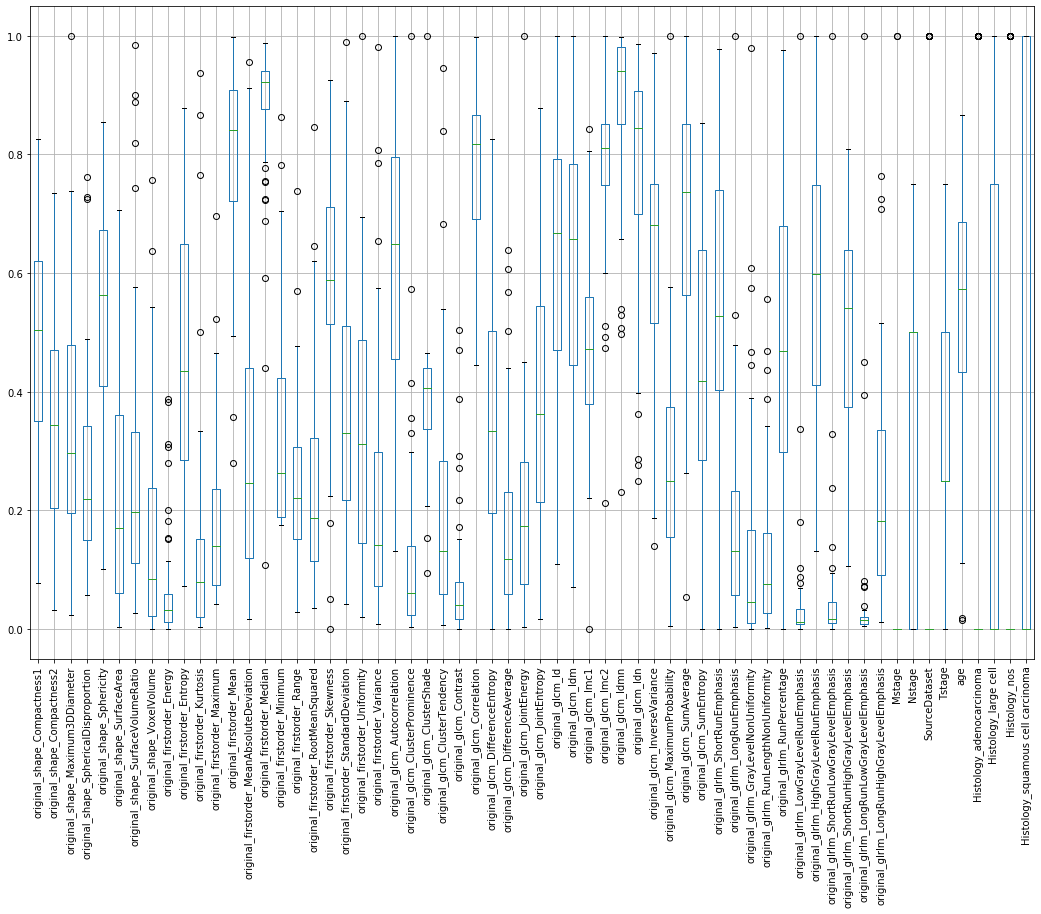

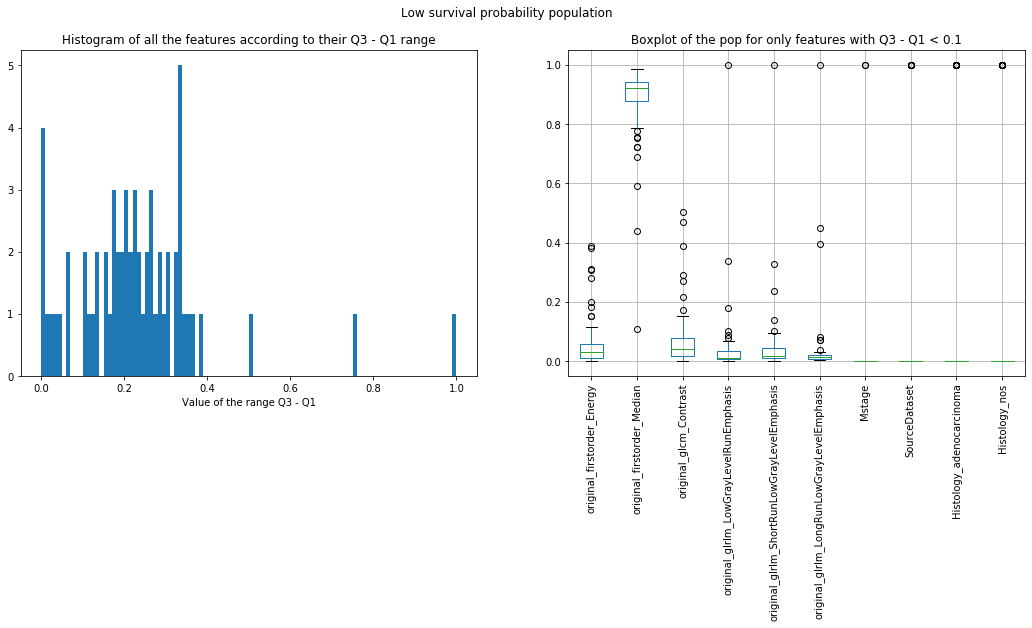

In [0]:
""" Statistics of the low survival probability population """
threshold = 0.1
low_surv_df.boxplot(figsize=(18,12), rot=90)
low_range_features_low_surv = small_range_Q3_Q1(low_surv_df, threshold, 'Low survival probability population')
low_surv_df.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Mstage,Nstage,SourceDataset,Tstage,age,Histology_adenocarcinoma,Histology_large cell,Histology_nos,Histology_squamous cell carcinoma
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0,25.000000,25.00,25.000000,25.000000,25.000000,25.0,25.0,25.000000
mean,0.528699,0.386053,0.155596,0.227251,0.580191,0.073387,0.472101,0.039533,0.034618,0.734970,0.024867,0.109627,0.554875,0.495485,0.650454,0.320207,0.179325,0.474403,0.736546,0.525071,0.107190,0.336683,0.393118,0.099645,0.409509,0.284323,0.220431,0.567119,0.659199,0.408316,0.042805,0.700291,0.259666,0.234801,0.710847,0.702529,0.642363,0.464326,0.349054,0.083082,0.488122,0.714498,0.861373,0.026976,0.033689,0.055575,0.843027,0.064009,0.366474,0.084139,0.388971,0.027857,0.055315,0.0,0.060000,0.96,0.180000,0.492954,0.840000,0.0,0.0,0.160000
std,0.168850,0.166702,0.127233,0.146776,0.167243,0.128119,0.198965,0.112869,0.056018,0.186326,0.033660,0.083138,0.238076,0.190812,0.263802,0.144562,0.093458,0.222941,0.107936,0.171027,0.137891,0.181667,0.235517,0.078453,0.070431,0.156726,0.152921,0.183115,0.164902,0.180587,0.071091,0.197514,0.183816,0.187780,0.106989,0.143232,0.175442,0.188608,0.239835,0.103035,0.223932,0.201401,0.128670,0.035352,0.113364,0.151448,0.145172,0.060426,0.228619,0.075112,0.230428,0.031181,0.053474,0.0,0.165831,0.20,0.244949,0.185810,0.374166,0.0,0.0,0.374166
min,0.121875,0.053049,0.019842,0.029617,0.155439,0.003902,0.053241,0.000987,0.000609,0.177803,0.003280,0.032813,0.060449,0.097520,0.132712,0.174419,0.075472,0.080177,0.475822,0.158818,0.009864,0.045088,0.072969,0.008526,0.277496,0.031031,0.022961,0.226483,0.233236,0.074541,0.001337,0.158990,0.021111,0.000551,0.468394,0.405984,0.384392,0.188914,0.014852,0.001273,0.130378,0.135793,0.454677,0.000000,0.000339,0.001270,0.388663,0.002905,0.087059,0.004656,0.102891,0.001823,0.006737,0.0,0.000000,0.00,0.000000,0.070881,0.000000,0.0,0.0,0.000000
25%,0.445939,0.287041,0.077003,0.1

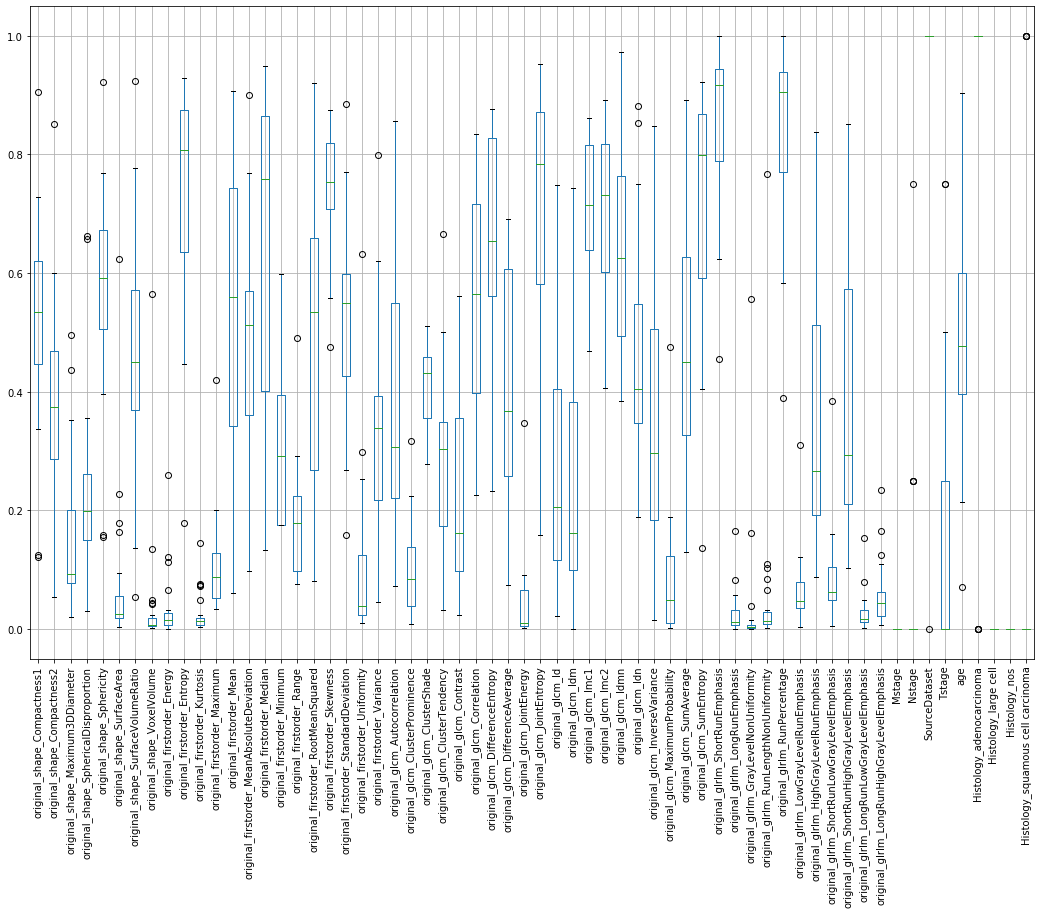

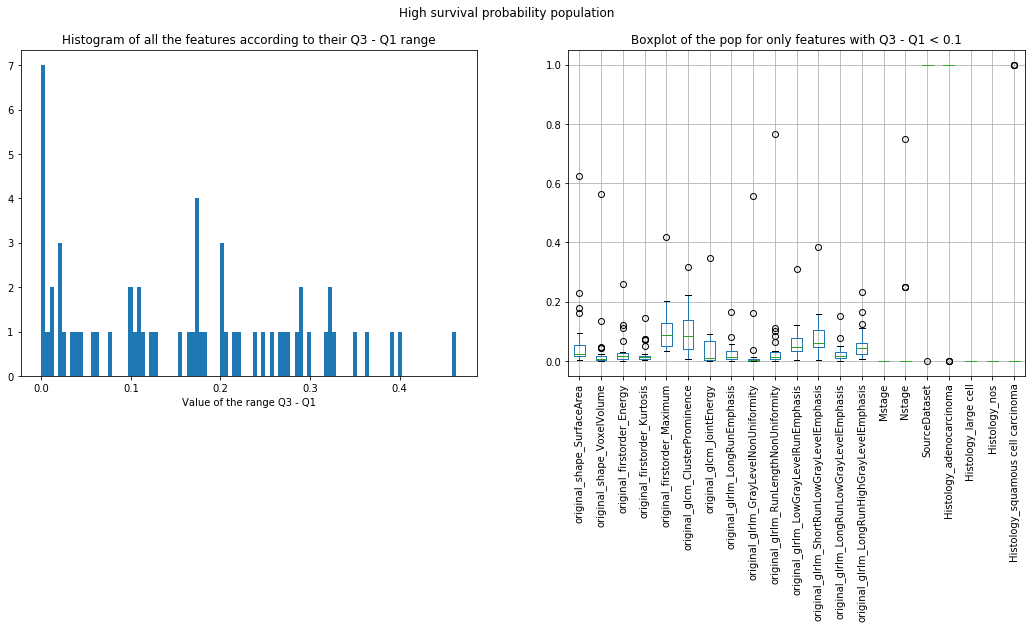

In [0]:
""" Statistics of the high survival probability population """
high_surv_df.boxplot(figsize=(18,12), rot=90)
low_range_features_high_surv = small_range_Q3_Q1(high_surv_df, threshold, 'High survival probability population')
high_surv_df.describe()

In [0]:
""" Intersection of low quantile range features extracted from both population """
# print(low_range_features_low_surv)
# print(low_range_features_high_surv)
intersection_features = list(set(low_range_features_low_surv) & set(low_range_features_high_surv))
union_features = list(low_range_features_low_surv) + list(set(low_range_features_high_surv) - set(low_range_features_low_surv))
print('Features with low range in both population', intersection_features)
print('Features with low range in one of the population', union_features)

Features with low range in both population ['original_glrlm_LongRunLowGrayLevelEmphasis', 'Histology_nos', 'SourceDataset', 'original_firstorder_Energy', 'Mstage', 'Histology_adenocarcinoma', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glrlm_LowGrayLevelRunEmphasis']
Features with low range in one of the population ['original_firstorder_Energy', 'original_firstorder_Median', 'original_glcm_Contrast', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'Mstage', 'SourceDataset', 'Histology_adenocarcinoma', 'Histology_nos', 'Nstage', 'original_glrlm_RunLengthNonUniformity', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_LongRunEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_firstorder_Kurtosis', 'original_shape_VoxelVolume', 'original_shape_SurfaceArea', 'Histology_large cell', 'original_firstorder_Maximum', 'original_glcm_JointEnergy', 'original_glcm_ClusterPromi

In [0]:
""" Comparing the mean value of the features in both populations """
feat_ = union_features
s1 = low_surv_df[feat_].describe().loc['mean']
s2 = low_surv_df[feat_].describe().loc['std']
s3 = low_surv_df[feat_].describe().loc['75%'] - low_surv_df[feat_].describe().loc['25%']
s4 = high_surv_df[feat_].describe().loc['mean']
s5 = high_surv_df[feat_].describe().loc['std']
s6 = high_surv_df[feat_].describe().loc['75%'] - high_surv_df[feat_].describe().loc['25%']

df = pd.concat([s1, s2, s3, s4, s5, s6], axis=1)
df.columns = ['low_surv_df_mean', 'low_surv_std', 'low_surve_Q3Q1_range', 'high_surv_df_mean', 'high_surv_std', 'high_surv_Q3Q1_range']
df

,low_surv_df_mean,low_surv_std,low_surve_Q3Q1_range,high_surv_df_mean,high_surv_std,high_surv_Q3Q1_range
original_firstorder_Energy,0.062212,0.089625,0.046987,0.034618,0.056018,0.020110
original_firstorder_Median,0.881046,0.135888,0.064901,0.650454,0.263802,0.463329
original_glcm_Contrast,0.075018,0.102829,0.062408,0.220431,0.152921,0.257434
original_glrlm_LowGrayLevelRunEmphasis,0.043276,0.129108,0.026656,0.064009,0.060426,0.044255
original_glrlm_ShortRunLowGrayLevelEmphasis,0.049672,0.129918,0.034814,0.084139,0.075112,0.056073
original_glrlm_LongRunLowGrayLevelEmphasis,0.043750,0.139397,0.011601,0.027857,0.031181,0.021123
Mstage,0.030303,0.172733,0.000000,0.000000,0.000000,0.000000
SourceDataset,0.106061,0.310275,0.000000,0.960000,0.200000,0.000000
Histology_adenocarcinoma,0.212121,0.411943,0.000000,0.840000,0.374166,0.000000
Histology_nos,0.166667,0.375534,0.000000,0.000000,0.000000,0.000000


**Conclusion**: The discriminating feature are `SourceDataset`, `Histology_adenocarcinoma`. 

### Classification of patients to determine low / high survival probability

In [0]:
""" Concatenate the values of both population and set labels for classification """
x_surv = low_surv_df.append(high_surv_df)
y_low_surv = pd.Series([0] * len(low_surv_df), index=low_surv_df.index, name='high_surv')
y_high_surv = pd.Series([1] * len(high_surv_df), index=high_survival_index, name='high_surv')
y_surv = y_low_surv.append(y_high_surv)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV

tuned_params = {"n_estimators": np.arange(10, 1000, 10),
                "min_samples_split": np.arange(2, 40, 2),
                "min_samples_leaf": np.arange(1, 20, 1)
                }

search = RandomizedSearchCV(RandomForestClassifier(), tuned_params, cv=5, verbose=2, n_jobs=-1, n_iter=500)
search.fit(x_surv, y_surv)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 24.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
params = search.best_params_
forest = RandomForestClassifier(**params, n_jobs=-1)
forest.fit(x_surv, y_surv)

""" Feature importance """
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_surv.shape[1]):
    print('{:<60}({:<10})+/-({:})'.format(x_surv.columns[indices[f]], importances[indices[f]], std[indices[f]]))

Feature ranking:
SourceDataset                                               (0.1197177173051919)+/-(0.32419945377556325)
original_glcm_Idn                                           (0.07421543949813186)+/-(0.24846002916289545)
original_glcm_Idmn                                          (0.07367625666376158)+/-(0.2471807948929842)
original_glcm_Imc1                                          (0.06418542097989306)+/-(0.22972901572179708)
original_glcm_Idm                                           (0.05779021272502332)+/-(0.22437457570516728)
original_glrlm_RunPercentage                                (0.055573740934851824)+/-(0.22215477048286453)
original_glrlm_LongRunEmphasis                              (0.05069006633754568)+/-(0.21344655556796932)
original_glcm_Id                                            (0.049710919405418795)+/-(0.21069395488134865)
original_glcm_DifferenceAverage                             (0.04768471059174412)+/-(0.20014716357582754)
original_glrlm_LongRunHighGra

In [0]:
high_importance_features_save = ['SourceDataset',
 'original_glcm_Idn',
 'original_glcm_Idmn',
 'original_glcm_Imc1',
 'original_glcm_Idm',
 'original_glrlm_RunPercentage',
 'original_glrlm_LongRunEmphasis',
 'original_glcm_Id',
 'original_glcm_DifferenceAverage',
 'original_glrlm_LongRunHighGrayLevelEmphasis']

# high_importance_features = [x_surv.columns[indices[f]] for f in range(10)]
# high_importance_features

## Covariance matrix

**Question**: how to exploit correlation matrix to eliminate non informative features?

https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4

In [0]:
import seaborn as sn

In [0]:
input_train, output_train, input_test = load_owkin_data()

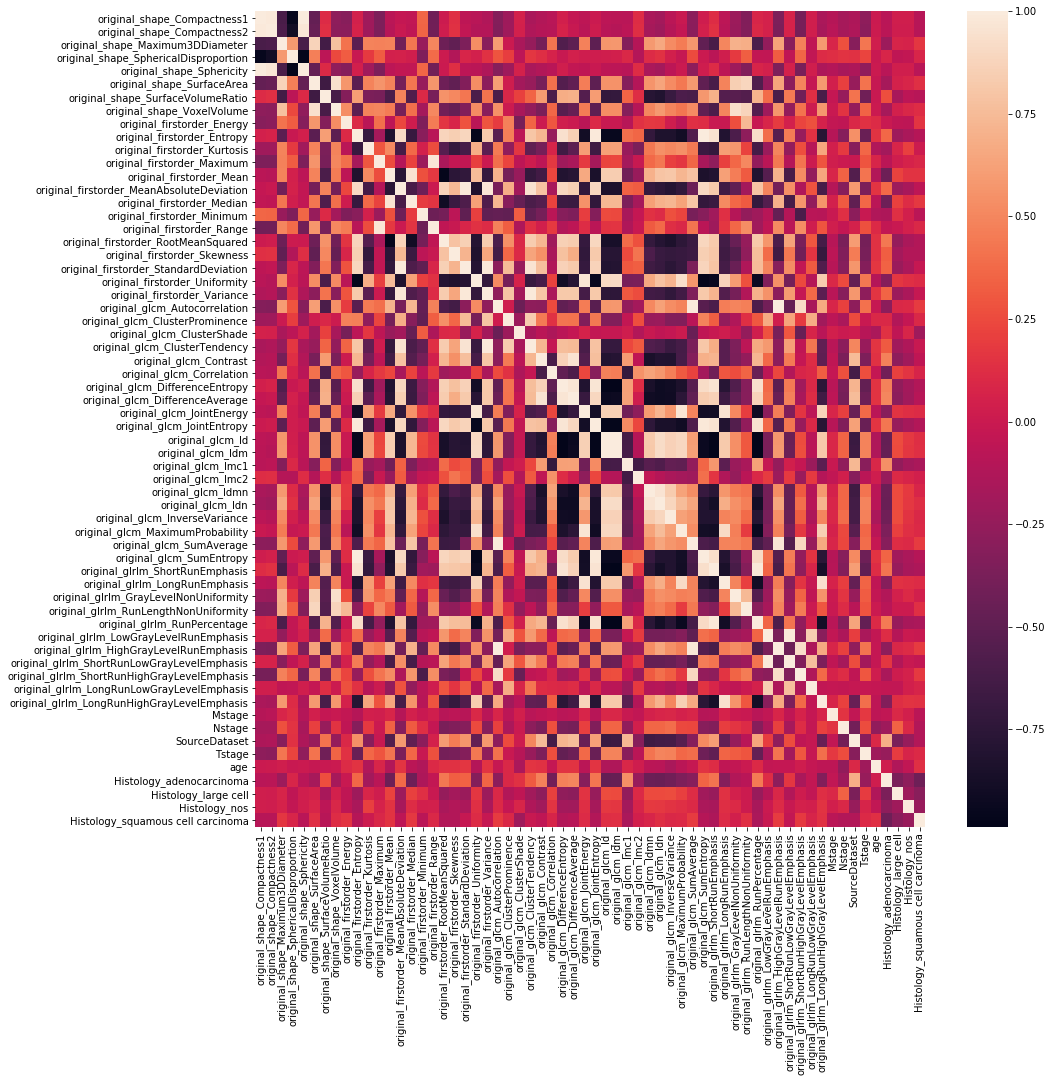

In [0]:
""" Correlation matrix """
plt.figure(figsize=(15,15))
corrMatrix = input_train.corr(method='pearson')
sn.heatmap(corrMatrix)

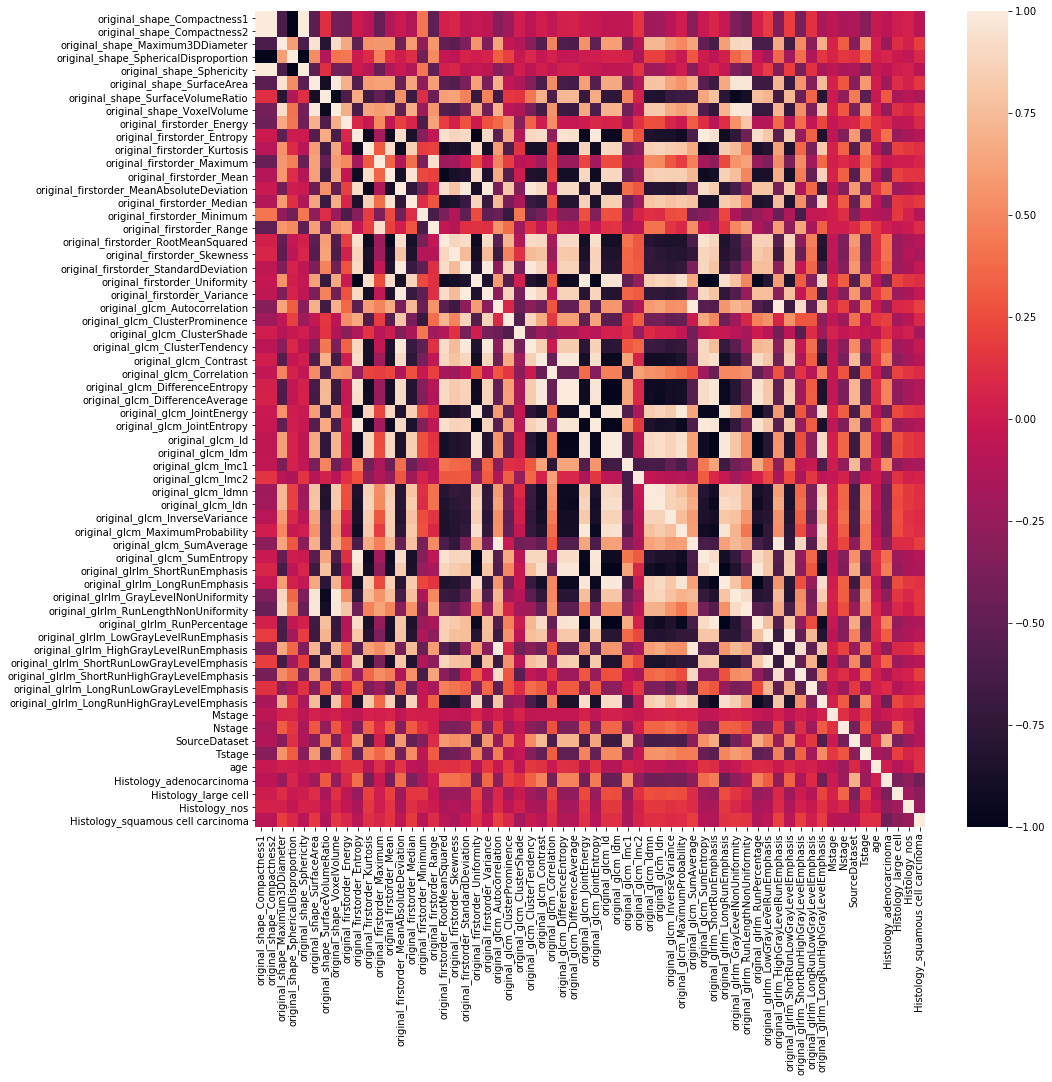

In [0]:
""" Correlation matrix """
plt.figure(figsize=(15,15))
corrMatrix = input_train.corr(method='spearman')
sn.heatmap(corrMatrix)

In [0]:
start_features = ['SourceDataset', 'Histology_adenocarcinoma']


# Variable selection

 ## LASSO

 See https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html#cox.
 Features are extracted in using the notebook ``lasso/FeatureSelectionLasso.ipynb``.

In [0]:
input_train, output_train, input_test = load_owkin_data()
std_input_train, std_input_test = normalizing_input(input_train, input_test)
std_input_train.to_csv('MergedStdTrainingInput.csv')

In [0]:
# Variables 

lasso_features_lamb_lse = ['original_shape_Maximum3DDiameter',
            'original_shape_VoxelVolume',
            'original_firstorder_Maximum',
            'original_firstorder_Mean',
            'original_glcm_ClusterProminence',
            'original_glrlm_GrayLevelNonUniformity',
            'original_glrlm_RunPercentage',
            'Mstage',
            'Nstage',
            'SourceDataset',
            'age',
            'Histology_nos']

lasso_features_lamb_min = ['original_shape_Maximum3DDiameter',
        'original_shape_VoxelVolume',
        'original_firstorder_Maximum',
        'original_firstorder_Mean',
        'original_glcm_ClusterProminence',
        'original_glrlm_GrayLevelNonUniformity',
        'original_glrlm_RunPercentage',
        'Mstage',
        'Nstage',
        'SourceDataset',
        'age',
        'Histology_nos']

lasso_features_fabrice = ['Mstage',
            'Nstage',
            'SourceDataset',
            'age',
            'original_shape_VoxelVolume',
            'original_firstorder_Maximum',
            'original_firstorder_Mean',
            'original_glcm_ClusterProminence',
            'original_glcm_Idm',
            'original_glcm_Idn',
            'original_glrlm_RunPercentage']       

In [0]:
input = "original_shape_Maximum3DDiameter''original_shape_VoxelVolume''original_firstorder_Maximum''original_firstorder_Mean''original_glcm_ClusterProminence''original_glrlm_GrayLevelNonUniformity''original_glrlm_RunPercentage''Mstage''Nstage''SourceDataset''age''Histology_nos"
features = input.split('\'\'')
features

['original_shape_Maximum3DDiameter',
 'original_shape_VoxelVolume',
 'original_firstorder_Maximum',
 'original_firstorder_Mean',
 'original_glcm_ClusterProminence',
 'original_glrlm_GrayLevelNonUniformity',
 'original_glrlm_RunPercentage',
 'Mstage',
 'Nstage',
 'SourceDataset',
 'age',
 'Histology_nos']

## Cross correlation

# Random surivival forest

In [0]:
!pip install scikit-survival
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import cross_validate

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 368 from PyObject
  return f(*args, **kwds)


In [0]:
def load_data(features=None):
    """ Load data for RSF usage """
    X_df, y_df, _ = load_owkin_data()
    if features != None:
        X_df = X_df[features]
    X = X_df.to_numpy()
    y = y_dataframe_to_rsf_input(y_df)
    return X_df, y_df, X, y

X_df, y_df, X, y = load_data(lasso_features_bis)
feature_name = list(X_df.columns.values)

"""
Train model
"""
params = {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
rsf = RandomSurvivalForest(n_estimators = params['n_estimators'],
                           min_samples_split = params['min_samples_split'],
                           min_samples_leaf = params['min_samples_leaf'],
                           max_features="sqrt",
                           n_jobs=-1
                           )
cross_validate(rsf, X, y, cv=5)

{'fit_time': array([0.11209631, 0.1188364 , 0.11608171, 0.11968184, 0.12150097]),
 'score_time': array([0.10321617, 0.10320401, 0.10330343, 0.10309672, 0.1030724 ]),
 'test_score': array([0.68773234, 0.62244124, 0.57537155, 0.70496324, 0.65698219])}

# CoxPH

In [0]:
# Prediction
def predict(model, X, threshold=0.9):
    prediction = model.predict_survival_function(X)
    y_pred = []
    for pred in prediction:
        time = pred.x
        survival_prob = pred.y
        i_pred = 0
        while i_pred < len(survival_prob) - 1 and survival_prob[i_pred] > threshold:
            i_pred += 1
        y_pred.append(time[i_pred])
    return pd.DataFrame(np.array([[y, np.nan] for y in y_pred]), index=X.index, columns=['SurvivalTime', 'Event'])

## Baseline

In [0]:
features_baseline = ['original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio',
                      'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy', 'original_glcm_Id',
                      'original_glcm_Idm', 'SourceDataset', 'Nstage']

In [147]:
!pip install scikit-survival
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sksurv.util import Surv

     |████████████████████████████████| 1.8MB 4.4MB/s 
     |████████████████████████████████| 153kB 24.6MB/s 
ERROR: Operation cancelled by user


ModuleNotFoundError: ignored

In [0]:
""" Select features """
features = lasso_features_lamb_lse

# Read data
input_train, output_train, input_test = load_owkin_data()
input_train = input_train[features]
input_test = input_test[features]
input_train, input_test = normalizing_input(input_train, input_test)
structured_y = Surv.from_dataframe('Event', 'SurvivalTime', output_train)

# Grid search
tuned_params = {"alpha": np.linspace(0.5, 4, 1000)
                }
grid_search = RandomizedSearchCV(CoxPHSurvivalAnalysis(), tuned_params, cv=5, n_jobs=-1, n_iter=500)
grid_search.fit(input_train, structured_y)
print(grid_search.best_score_)
best_params = grid_search.best_params_
print(best_params)

0.6977574356007257
{'alpha': 1.7052052052052051}


## Coxnet

In [0]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sksurv.util import Surv

In [0]:
""" Select features """
features = high_importance_features_save

# Read data
input_train, output_train, input_test = load_owkin_data()
input_train = input_train[features]
input_test = input_test[features]
input_train, input_test = normalizing_input(input_train, input_test)
structured_y = Surv.from_dataframe('Event', 'SurvivalTime', output_train)

# Grid search
tuned_params = {"l1_ratio": np.linspace(0.0027, 0.0028, 1000),
                "n_alphas": range(65, 75, 1),
                }
grid_search = RandomizedSearchCV(CoxnetSurvivalAnalysis(), tuned_params, cv=5, n_jobs=-1, n_iter=500)
grid_search.fit(input_train, structured_y)
print(grid_search.best_score_)
best_params = grid_search.best_params_
print(best_params)

0.6752380060945123
{'n_alphas': 74, 'l1_ratio': 0.0027425425425425427}


In [0]:
# Prediction
def predict(model, X, threshold=0.9):
    prediction = model.predict_survival_function(X)
    y_pred = []
    for pred in prediction:
        time = pred.x
        survival_prob = pred.y
        i_pred = 0
        while i_pred < len(survival_prob) - 1 and survival_prob[i_pred] > threshold:
            i_pred += 1
        y_pred.append(time[i_pred])
    return pd.DataFrame(np.array([[y, np.nan] for y in y_pred]), index=X.index, columns=['SurvivalTime', 'Event'])

coxph = CoxnetSurvivalAnalysis(**best_params, fit_baseline_model=True)
coxph.fit(input_train, structured_y)
y_pred = predict(coxph, input_test)
y_pred.to_csv('submission.csv')

# AutoML

In [153]:
!sudo apt-get install build-essential swig
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
import autosklearn.regression

In [0]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit, _validate_shuffle_split
from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples   

In [0]:
random_state = 42
val_size = 0.2
n_splits = 1
time_left_for_this_task = 600 #60 #600 # default : 3600 # in seconds
per_run_time_limit = 30 #30 # default : 360 # in seconds

In [0]:
""" Choose features for Autosklearn """
feat_ = all_features

input_train, output_train, input_test = load_owkin_data()
input_train, input_test = normalizing_input(input_train, input_test)
input_train = input_train[feat_]
input_test = input_test[feat_]

In [0]:
class ShuffleSplit(BaseShuffleSplit):
    
    def __init__(self, n_splits=10, test_size=None, train_size=None,
                 random_state=None):
        n_splits = 1 # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! PROBLEM : n_splits stays at 10 even when changing default value

        super().__init__(
            n_splits=n_splits,
            test_size=test_size,
            train_size=train_size,
            random_state=random_state)
        self._default_test_size = 0.1

    def _iter_indices(self, X, y=None, groups=None):
        n_samples = _num_samples(X)
        n_train, n_test = _validate_shuffle_split(
            n_samples, self.test_size, self.train_size,
            default_test_size=self._default_test_size)

        rng = check_random_state(self.random_state)
        for i in range(self.n_splits):
            # random partition
            permutation = rng.permutation(n_samples)
            ind_test = permutation[:n_test]
            ind_train = permutation[n_test:(n_test + n_train)]
            yield ind_train, ind_test

In [187]:
suffle_split = ShuffleSplit(n_splits=n_splits, test_size=val_size, random_state=random_state)
ind_train, ind_val = [_tuple for _tuple in suffle_split._iter_indices(input_train, 
                                                                      y=output_train["SurvivalTime"], 
                                                                      groups=None)][0]
n_train = len(ind_train)
n_val = len(ind_val)
print("n_train", n_train)
print("n_val", n_val)

n_train 240
n_val 60


In [0]:
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=time_left_for_this_task, # in seconds
                                                     per_run_time_limit=per_run_time_limit,
                                                     resampling_strategy=ShuffleSplit,
                                                     resampling_strategy_arguments={'n_splits': n_splits,
                                                                                    'test_size': val_size,
                                                                                    'random_state': random_state})

In [189]:
available_models = [model_name for model_name in autosklearn.pipeline.components.regression._regressors]
print("Available models in AutoSklearnRegressor : ")
available_models

Available models in AutoSklearnRegressor : 


['adaboost',
 'ard_regression',
 'decision_tree',
 'extra_trees',
 'gaussian_process',
 'gradient_boosting',
 'k_nearest_neighbors',
 'liblinear_svr',
 'libsvm_svr',
 'random_forest',
 'ridge_regression',
 'sgd']

In [0]:
def my_cindex(y_true, y_pred, patient_ids, events, ind_train, ind_val, n_train, n_val, print_cindex=True):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    
    if len(y_true)==n_train:
        ind = ind_train
    elif len(y_true)==n_val:
        ind = ind_val
    else:
        raise Exception("y_true.shape={} but should be either {} or {}".format(y_true.shape, n_train, n_val))

    df_y_true = pd.DataFrame({"PatientID": patient_ids[ind],
                              "SurvivalTime": y_true,
                              "Event": events[ind]
                             })
    df_y_true = df_y_true.set_index("PatientID")

    df_y_pred = pd.DataFrame({"PatientID": patient_ids[ind],
                              "SurvivalTime": y_pred,
                              "Event": events[ind]*np.nan # because "`Event`column, whose value does not matter" in metrics_t9gbvr2.py
                             })
    df_y_pred = df_y_pred.set_index("PatientID")
    
    cindex_value = cindex(df_y_true, df_y_pred)
    
    if print_cindex:
        if len(y_true)==n_train:
            print("train_cindex", cindex_value)
        else:
            print("val_cindex", cindex_value)
        
    return cindex_value


cindex_scorer = autosklearn.metrics.make_scorer(name="cindex",
                                                score_func=my_cindex,
                                                optimum=1,
                                                greater_is_better=True,
                                                needs_proba=False,
                                                needs_threshold=False,
                                                patient_ids = output_train.index.values,
                                                events = output_train["Event"].values,
                                                ind_train = ind_train,
                                                ind_val = ind_val,
                                                n_train = n_train,
                                                n_val = n_val,
                                                print_cindex=False)

In [191]:
import time
start_time = time.time()
automl.fit(input_train.copy(), 
           output_train["SurvivalTime"].copy(),
           metric=cindex_scorer)
execution_time = time.time()-start_time

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  out[key] = value


[WARNING] [2020-03-17 16:47:03,313:AutoMLSMBO(1)::00397eeee2209964c15547d243aac9a1] Could not find meta-data directory /usr/local/lib/python3.6/dist-packages/autosklearn/metalearning/files/cindex_regression_dense
[WARNING] [2020-03-17 16:47:03,395:EnsembleBuilder(1):00397eeee2209964c15547d243aac9a1] No models better than random - using Dummy Score!
[WARNING] [2020-03-17 16:47:03,423:EnsembleBuilder(1):00397eeee2209964c15547d243aac9a1] No models better than random - using Dummy Score!


In [192]:
execution_time

597.4781317710876

In [193]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: 00397eeee2209964c15547d243aac9a1
  Metric: cindex
  Best validation score: 0.703090
  Number of target algorithm runs: 97
  Number of successful target algorithm runs: 82
  Number of crashed target algorithm runs: 11
  Number of target algorithms that exceeded the time limit: 3
  Number of target algorithms that exceeded the memory limit: 1



In [195]:
start_time = time.time()
automl.refit(input_train.iloc[ind_train].copy(), output_train.iloc[ind_train]["SurvivalTime"].copy())
execution_time = time.time()-start_time
print("execution_time", execution_time)

execution_time 8.015268325805664


In [199]:
print("resampling_strategy :", automl.resampling_strategy.__name__)
print(automl.sprint_statistics())

resampling_strategy : ShuffleSplit
auto-sklearn results:
  Dataset name: 00397eeee2209964c15547d243aac9a1
  Metric: cindex
  Best validation score: 0.703090
  Number of target algorithm runs: 97
  Number of successful target algorithm runs: 82
  Number of crashed target algorithm runs: 11
  Number of target algorithms that exceeded the time limit: 3
  Number of target algorithms that exceeded the memory limit: 1



In [0]:
y_test_pred = automl.predict(input_test)
y_pred_df = pd.DataFrame(np.array([[y, np.nan] for y in y_test_pred]), index=input_test.index, columns=['SurvivalTime', 'Event'])
y_pred_df.to_csv('submission.csv')

End